# Deep Learning
## Dogs vs Cats

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import random
from PIL import Image
import tensorflow as tf
import shutil

## File path to datasets

In [3]:
training_images = "../lab_2/original_data/train/train"
test_images = "../lab_2/original_data/test/test"

train_size = len([name for name in os.listdir(training_images)])
test_size = len([name for name in os.listdir(test_images)])

train_size

19991

In [4]:
test_size

12487

0. EDA och filhantering (*)
- a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder, glöm inte att lägga till den till .gitignore.
- b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln


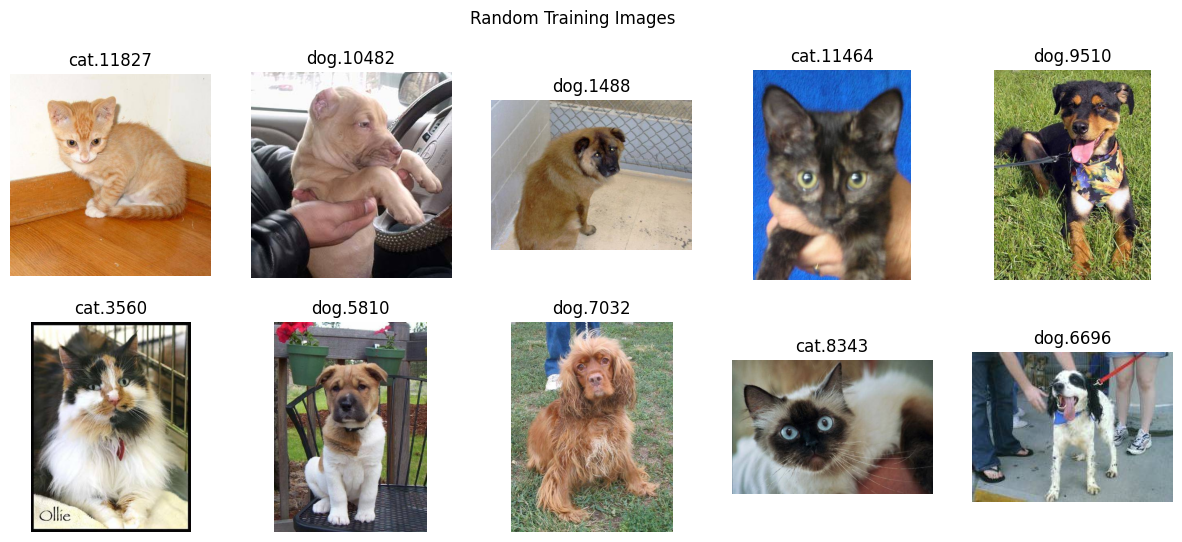

In [5]:

image_files = os.listdir(training_images)

# Select 10 random images
random_images = random.sample(image_files, 10)

# Plot 
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Random Training Images')

for i, image_file in enumerate(random_images):
    image_path = os.path.join(training_images, image_file)
    image = Image.open(image_path)
    
    label = '.'.join(image_file.split('.')[:2])  # Split after the second "."

    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')

plt.show()

c) Skapa folderstrukturen nedan med Python:

```
.
├── experiment_small_data
│   ├── test
│   ├── train
│   └── val
├── experiment_tiny_data
│   ├── test
│   ├── train
│   └── val
├── lab.ipynb
└── original_data
 ├── test
 │   └── test
 └── train
 └── train

```

In [6]:
# current directory
base_dir = os.getcwd()

# Define main experiment folders
experiments = ["experiment_small_data", "experiment_tiny_data"]

# Define subfolders
subfolders = ["test", "train", "val"]

# Create folders
for experiment in experiments:
  experiment_path = os.path.join(base_dir, experiment)
  if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)  # Create experiment directory

  # Create subfolders within each experiment
  for subfolder in subfolders:
    subfolder_path = os.path.join(experiment_path, subfolder)
    if not os.path.exists(subfolder_path):
      os.makedirs(subfolder_path)

d) Nu ska du göra train|val|test split med följande splits:

experiment_small

    train - 1600 (800 dogs, 800 cats)
    val - 400 (200 dogs, 200 cats)
    test - 500 (250 dogs, 250 cats)

In [7]:
experiment_path = "experiment_small_data"

# Function to move images to each respective subfolder based on target numbers
def move_images_to_subfolders():
    # Define the target numbers of images per subfolder
    target_counts = {
        "train": {"dog": 800, "cat": 800},
        "val": {"dog": 200, "cat": 200},
        "test": {"dog": 250, "cat": 250}
    }
    
    # Iterate over each subfolder and move images
    for subfolder, label_counts in target_counts.items():
        # Get list of images to move
        images_to_move = [f for f in os.listdir(training_images)]
        # Shuffle the list of images for randomness
        random.shuffle(images_to_move)
        
        # Move the correct number of images containing "cat" and "dog" to the subfolder
        for label, count in label_counts.items():
            # Filter images containing the current label
            label_images = [image for image in images_to_move if label in image]
            # Move the specified number of images for the label
            for image in label_images[:count]:
                src = os.path.join(training_images, image)
                dest = os.path.join(experiment_path, subfolder, image)
                shutil.move(src, dest)

# Call the function to move images to each respective subfolder ("commented" to avoid multiple additions)
#move_images_to_subfolders()


Check if the count is right

In [8]:
for subfolder in subfolders:
    subfolder_path = os.path.join(experiment_path, subfolder)
    dogs_count = len([name for name in os.listdir(subfolder_path) if "dog" in name])
    cats_count = len([name for name in os.listdir(subfolder_path) if "cat" in name])
    print(f"Subfolder: {subfolder}")
    print(f"Number of dogs: {dogs_count}")
    print(f"Number of cats: {cats_count}")
    print()


Subfolder: test
Number of dogs: 250
Number of cats: 250

Subfolder: train
Number of dogs: 800
Number of cats: 800

Subfolder: val
Number of dogs: 200
Number of cats: 200



e) Läs in dataseten från experiment_small, experiment_tiny (BONUS) och plocka ut labelsvektorer, som ska vara one-hot encoded med 0 och 1.

- plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
- skapa lämplig plot för att kontrollera att dataseten är balanserade
- skapa lämplig plot för att kontrollera att dataseten är slumpade, dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]

In [9]:
datapath = Path().absolute().parent / "lab_2/experiment_small_data" / "train"

train_images = [plt.imread(path) for path in datapath.glob("*.jpg")]

len(train_images)

1600

In [10]:
train_images[0].shape, train_images[1].shape

((239, 320, 3), (423, 320, 3))

In [11]:
train_filenames = [str(path) for path in datapath.glob("*.jpg")]

random.shuffle(train_filenames)

len(train_filenames)

1600

#### 1. a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot
- decided to take this plot here since I was already counting on rezing the images in the function load_images_and_labels

In [12]:
heights = [image.shape[0] for image in train_images]
widths = [image.shape[1] for image in train_images]
heights[:10]

[239, 423, 120, 375, 469, 500, 375, 375, 422, 288]

In [13]:
widths[:10]

[320, 320, 159, 499, 450, 332, 499, 499, 499, 255]

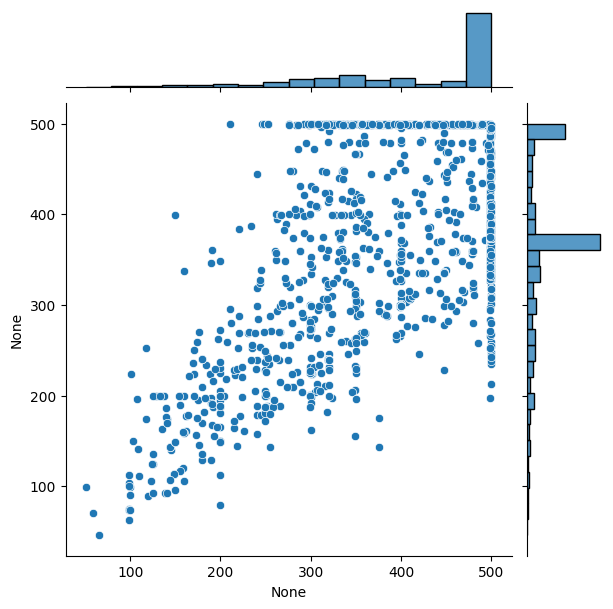

In [14]:
import seaborn as sns 

sns.jointplot(x=widths, y=heights)

In [15]:
def load_images_and_labels(train_filenames, target_size=(150, 150)):
    images = []
    labels = []
    
    for filename in train_filenames:
        image = Image.open(filename)
        # Resize image to a fixed size
        image = image.resize(target_size)
        # Image -> Numpy Array conversion
        image_array = np.array(image) / 255.0
        # Append the image array to the list of images
        images.append(image_array)
        
        # Extract the label 
        label = 1 if "dog" in filename else 0
        # Append label 
        labels.append(label)
    
    # Convert the lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

train_images, train_labels = load_images_and_labels(train_filenames)

train_images.shape

(1600, 150, 150, 3)

In [16]:
train_images[0].shape

(150, 150, 3)

In [17]:
train_labels

array([1, 0, 1, ..., 1, 1, 0])

In [18]:
"dog" in train_filenames[1]

False

Plotting some train images

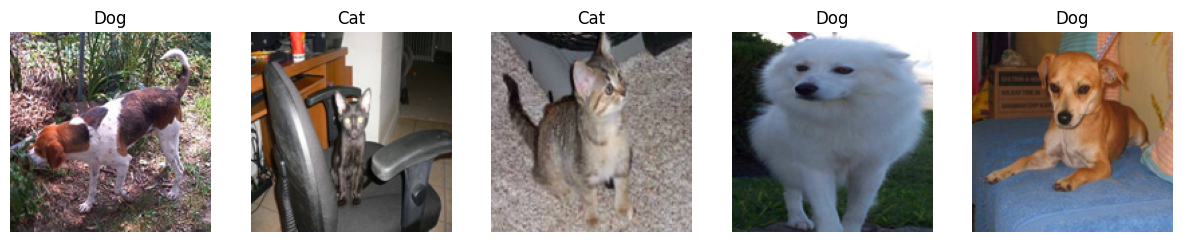

In [19]:
def plot_images(images, labels, num_images=5):
    # Randomly select num_images
    indices = np.random.choice(len(images), size=num_images, replace=False)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, idx in enumerate(indices):
        axes[i].imshow(images[idx])
        axes[i].set_title("Dog" if labels[idx] == 1 else "Cat")
        axes[i].axis('off')
    plt.show()

plot_images(train_images, train_labels)

Distribution of classes 

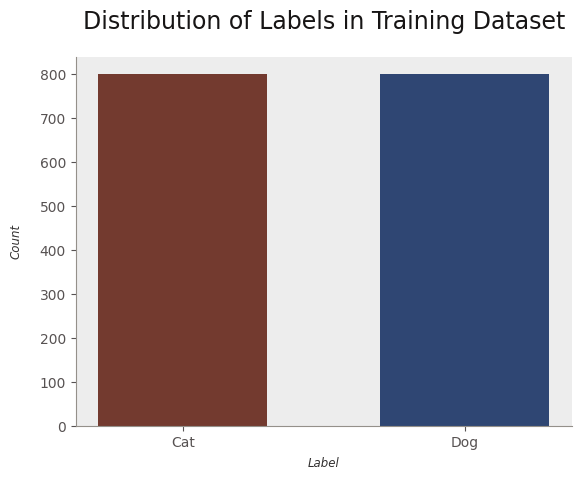

In [55]:
def plot_label_distribution(labels):
    # Count the occurrences of each label
    label_counts = np.bincount(labels)
    
    # Create the plot
    fig, ax = plt.subplots()
    ax.bar(["Cat", "Dog"], label_counts, color=['#733A2F', '#2F4673'], width=0.6)
    
    ax.set_facecolor('#EDEDED')
    #fig.patch.set_facecolor('#D9D7CC')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#94908A')
    ax.spines['bottom'].set_color('#94908A')
    ax.tick_params(axis='x', colors='#575252')
    ax.tick_params(axis='y', colors='#575252')
    ax.xaxis.label.set_color('#333131')
    ax.yaxis.label.set_color('#333131')
    ax.title.set_color('#171515')
    
    # Set labels and title
    ax.set_xlabel('Label', labelpad=5, fontstyle='italic', fontsize=8.5)
    ax.set_ylabel('Count', labelpad=12, fontstyle='italic', fontsize=8.5)
    ax.set_title('Distribution of Labels in Training Dataset', fontsize=17, pad=20)
    
    # Display the plot
    plt.show()

plot_label_distribution(train_labels)
# its balanced. Good!


### Randomization check 
- Here I experiment with creating an ASK or FSK style waveform to visualize the label dististribution in the array.

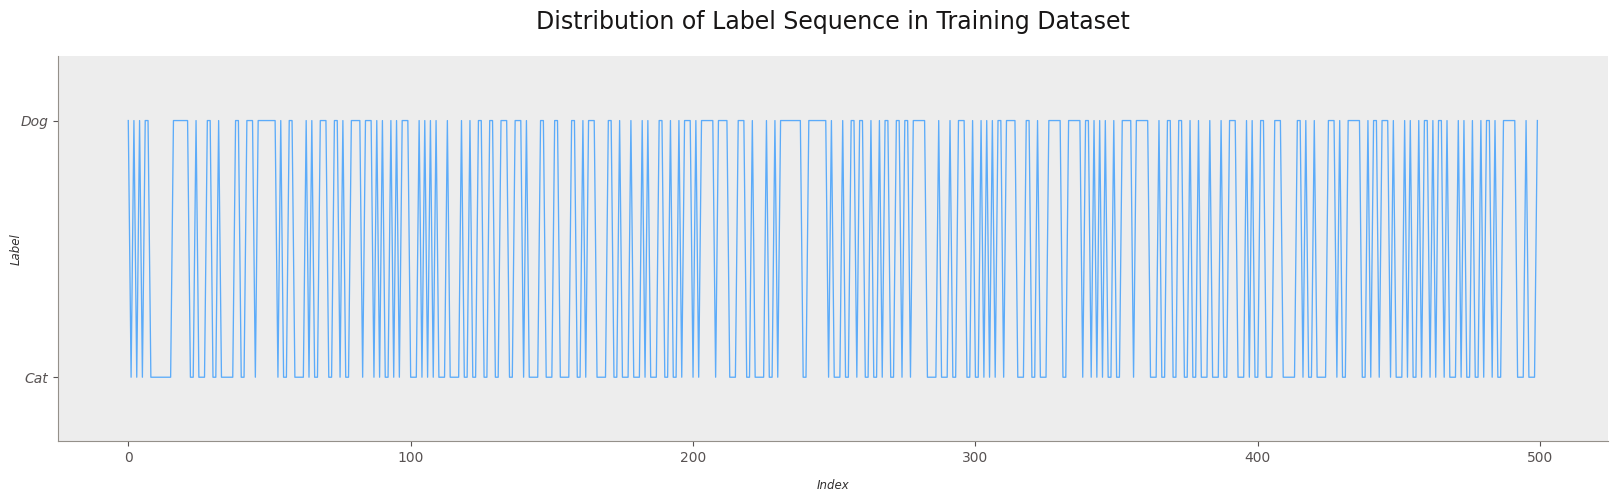

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot "FSK style" waveform of label sequence
def plot_label_waveform(train_labels):
    # Set the amplitude
    cat_amp = -1
    dog_amp = 1
    

    indices = np.arange(len(train_labels))
    
    # Create an empty array to store the y-values
    y_values = []
    
    # Initialize the previous label
    prev_label = None
    
    # Iterate through the labels and assign the corresponding y-value
    for label in train_labels:
        if prev_label is None or label != prev_label:
            y_values.append(label * dog_amp + (1 - label) * cat_amp)
        else:
            y_values.append(y_values[-1])
        prev_label = label
    
    # plot
    fig, ax = plt.subplots(figsize=(20, 5))
    
    ax.plot(indices, y_values, color='dodgerblue', alpha=0.7, linewidth=0.95)
    
    # Customize the appearance
    ax.set_facecolor('#EDEDED')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#94908A')
    ax.spines['bottom'].set_color('#94908A')
    ax.tick_params(axis='x', colors='#575252')
    ax.tick_params(axis='y', colors='#575252')
    ax.xaxis.label.set_color('#333131')
    ax.yaxis.label.set_color('#333131')
    ax.title.set_color('#171515')
    
    ax.set_xlabel('Index', labelpad=10, fontstyle='italic', fontsize=8.5)
    ax.set_ylabel('Label', labelpad=-2, fontstyle='italic', fontsize=8.5)
    ax.set_title('Distribution of Label Sequence in Training Dataset', fontsize=17, pad=20)
    
    ax.set_yticks([-1, 1])
    ax.set_yticklabels(['Cat', 'Dog'], fontstyle='italic')
    ax.set_ylim(-1.5, 1.5)
    
    plt.show()

# Example usage
plot_label_waveform(train_labels[:500])


c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande
struktur:

(samples, row, cols, color_channels)

Visualisera därefter ett par styckena bilder

In [22]:
# It seems to me that train_images already has the desired structure 

train_images.shape

(1600, 150, 150, 3)

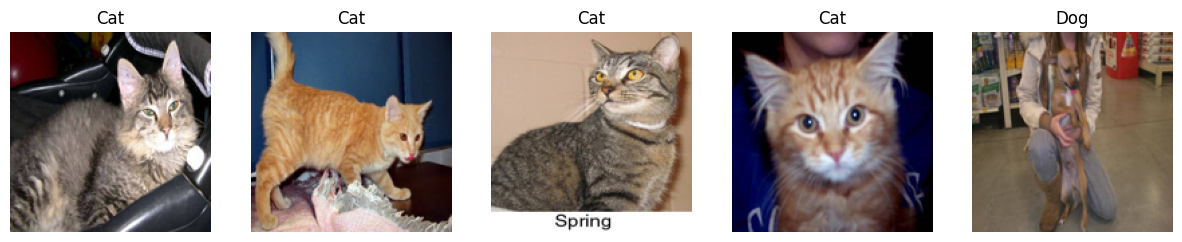

In [23]:
plot_images(train_images, train_labels)